# Project: Dynamics of Bargaining Power

# Standard Dynamic Model - Continuous Actions
# SDPA


#### Genaro Basulto 
#### 2022

This code was made specifically to solve the dynamyc single objective principal-agent problem. 

This aplication uses the JuMP library and the Ipopt solver to solve the optimization problrem given a value for the bargaining power.

The use uf this library allows us to easily change the parametrization of the problem and rely on a robust solver to find solutions in multi-criteria non-linear restricted optimization problems. 

### Libraries

In [1]:
using JuMP, Ipopt # Loading optimization libraries.
                  # Ipopt solve a nonlinear optimization problem.
using DataFrames  # Loading frame libraries.
using ExcelFiles, XLSX  # Loading excel files libraries.
using Plots, Plots.PlotMeasures    # Plots packages load

### Utility Functions

In [2]:
v(c, h=0.5) =  (c^(1-h))/(1-h) #CRA Function 
                                    #h is a oefficient of risk aversion
                                    # a is the agent effort

u(y,w)=y-w  #Declaration of the principal utility function 
            #y is the current output
            #w is the salary paid to the agent
paretopdf(a,L,H,x) = (a*(L^a)*(x^(-a-1)))/(1-(L/H)^a)
paretocdf(a,L,H,x) = (((L/x)^a)*log(x/L)*(1-(L/H)^a)-((L/H)^a)*log(H/L)*(1-(L/x)^a))/((1-(L/H)^a)^2)

paretocdf (generic function with 1 method)

### Variables and Lists

In [14]:
Y = [0.4 0.8]  # Outcomes set [yl yh]
beta = 0.96    # Future discount factor
h = 0.5 #Risk AdversionParameter for agent utility 
N = 100    # Number of intervals for the state variable
Max_iter = 100 #Max number of iterations 
a_l = 0.1
digits_tol = 3 #Digits of precision of the solution  
VFH=ones(100)*100
VFL=ones(100)

100-element Array{Float64,1}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0

### Effort Model Specification

In [21]:
function Model_Effort(k, P, Q, h, V, U0, start_xl = Y[1]/2, start_xh = Y[2]/2, L=Y[1], H=Y[2], x = (Y[1]+Y[2])/2)
    """
    This functions declares and solves the High effort model for the principal utility
    Returns optimal values if found 
    """
    model = Model(
            with_optimizer(
                Ipopt.Optimizer, 
                tol = 1e-7, 
                max_iter = 1000,
                print_level=0)) 

    # Declare the decision variables for the model: xl = wl, xh = wh.
    @variable(model, xl >= 0.00001, start = start_xl)  # xl = wl, low compensation.
    @variable(model, xh >= 0.00001, start = start_xh)  # xh = wh, hight compensation.
    @variable(model, a >= a_l, start = 1)  # Optimal action
    
    # Declare the agent's utility function within the model.
    register(model, :v, 2, v, autodiff=true)    # m, the model name
                                            # :v,  **********                                          
                                            # 2, number of variables
                                            # v, declare the agent's utility function 
                                            # autodiff,    **********
    register(model, :u, 2, u, autodiff=true) 
    register(model, :paretocdf, 4, paretocdf, autodiff=true) 
    register(model, :paretopdf, 4, paretopdf, autodiff=true)  
    
    # Non-linear type expressions are declared, the expected utility of the agent, within the model. 
    EV = @NLexpression(model, paretocdf(a,L,H,x)*(v(xh,h)+beta*V[P])+(1-paretocdf(a,L,H,x))*(v(xl,h)+beta*V[Q])-a)  # E(v|a)
    EU = @NLexpression(model, paretocdf(a,L,H,x)*(u(Y[2],xh)+beta*U0[P])+(1-paretocdf(a,L,H,x))*(u(Y[1],xl)+beta*U0[Q])) #E(U|a)
    
    # Objective function; expected utility of the principal and the agent given ah.
    @NLobjective(model, Max, EU) 

    @constraint(model, xh<=Y[2])  # Financial capacity restriction for high compensation; wh<=yh.
    @constraint(model, xl<=Y[1])  # Financial capacity restriction for low compensation; wl<=yl.
    @NLconstraint(model,  paretopdf(a,L,H,x)*(v(xh,h)-v(xl,h))-1 == 0)
    @NLconstraint(model, EV == V[k]) #Participation constraint to incentivize ah. 
    
    # The problem for incentive ah is solved.
    JuMP.optimize!(model) 

    #The optimal values are saved and returned
    wh = value(xh)
    wl = value(xl)
    a_opt = value(a)
    u_opt = paretocdf(a_opt,L,H,x)*(u(Y[2],wh)+beta*U0[P])+(1-paretocdf(a_opt,L,H,x))*(u(Y[1],wl)+beta*U0[Q])
    
    return u_opt, wl, wh, a_opt, termination_status(model)
end

Model_Effort (generic function with 6 methods)

In [22]:
vl = v(0, h)/(1-beta)-1 # State variable`s lower limit 
vh = v(Y[2],h)/(1-beta)-0.1  # State variable's upper limit
V = LinRange(vl, vh, N) # State variable's vector 
U0 = ones(100)
Model_Effort(50, 50, 50, h, V, U0)

(1.1582108744183721, 0.21536650989119843, 0.4533197372106336, 0.1, MathOptInterface.LOCALLY_SOLVED)

### Feasible Indexes 

In [23]:
function feasible_Indexes(h, V, U0)
    """
    This functions finds the indexes where the principal optimization problem has a feasible solution.
    Returns array of feasible indexes. 
    """
    K0 = 1:10 #Initial guess of possible feasible indexes
    KN = 30:70 #Final set of possible feasible indexes
    
    #loop while the initial set and the final set of indexes are different 
    while K0 != KN 
    
        K0 = KN 
        KN = []

        for k in K0 #loop for each index in the set

            fact = 0 #factibility indicator 

            for P in k:K0[end] # Loop for comparison value 1

                for Q in K0[1]:k # Loop for comparison value 2

                    stat = Model_Effort(k, P, Q, h, V, U0)[5] #Solve the model for high effort, return termination status
                    
                    if stat == MOI.LOCALLY_INFEASIBLE
                        stat = Model_Effort(k, P, Q, h, V, U0, Y[1], Y[2])[5]
                    end
                    
                    if (stat == MOI.LOCALLY_SOLVED) #check if the model for high effort on index k if feasible, if so exit the loopfor comprasion value 2 
                        fact=1 
                        break    
                    end

                end
                
                #if the index is feasible, break the loop for comprasion value 1 
                if fact == 1 
                    break
                end

            end
            
            #if the index is feasible, append it on the final set
            if fact == 1
                append!(KN, k)
            end

        end

        print(KN, "\n")

    end
    
    #Return the final set of feasible indexes
    return KN 
    
end

feasible_Indexes (generic function with 1 method)

### Routine 

In [24]:
function Dynamic_Pareto_Frontier(K, V, U0, UF, digits_tol, Max_iter, h)
    """
    This functions finds the stationary point of the Bellman Equation for
    the standard dynamic model.
    Returns optimal values if found 
    """
    
    iter=0 #Current number of method iteration 
    size_iter = length(K) #Size of the iteration 
    AcOpt = [] # List of optimal actions for K
    WHOpt = [] # List of hight optimal compensation for K
    WLOpt = [] # List of low optimal compensation for K
    VFH=zeros(100) #List of promised discounted utility for the principal if yh occurs.
    VFL=zeros(100) # List of promised discounted utility for the principal if yl occurs.
    for k in K
        VFH[k]=K[end]
        VFL[k]=K[1]
    end
    #loop while the initial value for the state variable is different from it's final value. 
    while round.(U0[K],digits = digits_tol)!=round.(UF[K],digits = digits_tol)
    
        AcOpt=[] #List of recomended actions 
        WHOpt=[] #List of compensations if yh occurs
        WLOpt=[] #List of compensations if yl occurs 
        U0[K]=UF[K] #Update state variable
        UF=zeros(100) #Final value of the state variable 

        for k in K # For each k in the feasible index set

            uval=0 #Value of the principal's current discounted utility 
            wl=0 #Low compensation 
            wh=0 #High compendation 
            accopt=0 #Recomended action 
            p=0 #Optimal comprasion value 1 
            q=0 #Optimal comprasion value 2 
 
            for P in k:min(K[end], Int(VFH[k])+3) # Loop for comparison value 1

                for Q in max(K[1],Int(VFL[k]-3)):k # Loop for comparison value 2

                    u_opt, xl, xh, a, stat = Model_Effort(k, P, Q, h, V, U0) #Effort Model is Solved
                    
                    if stat == MOI.LOCALLY_INFEASIBLE
                        u_opt, xl, xh, a, stat = Model_Effort(k, P, Q, h, V, U0, Y[1], Y[2])
                    end
                    
                    # If the principal's utility with the high effort action is higher than 0 and the model is feasible update the state variables
                    if (u_opt>uval) & (stat == MOI.LOCALLY_SOLVED)
                        uval=u_opt
                        wh=xh
                        wl=xl
                        p=P
                        q=Q
                        accopt=a
                    end
                    
                end
            end
            
            #The new values for the state variables are saved
            UF[k]=uval 
            append!(WHOpt, wh) 
            append!(WLOpt,wl)
            append!(AcOpt, accopt)
            VFH[k]=p
            VFL[k]=q
            
            if iter<=1 
                print("K= ", k, "  ul=", uval,"   wh=", wh, "   wl=", wl, "  P=",p,"  Q=",q,"  ", accopt, "\n")
            end
        end
        
        iter+=1 #Update number of iterations 
        println(iter)
        
        if iter == Max_iter #if the number of iterations is higher than the Max-iter, stationary point could not be found 
            break
        end

    end
    
    #Creation of the DataFrame
    DataEstPoint = DataFrame(
    K=K,
    Utilidad_Agente=V[K],
    Utilidad_Principal=U0[K],
    Compensacion_YH=WHOpt,
    Compensacion_YL=WLOpt,
    Accion_Recomendada=AcOpt, 
    VFH=VFH[K], 
    VFL=VFL[K])
    
    return DataEstPoint
end

Dynamic_Pareto_Frontier (generic function with 1 method)

### Loop for diferent values of h.

In [25]:
H = [0.50]
for h in H  
    vl = v(0, h)/(1-beta)-1 # State variable`s lower limit 
    vh = v(Y[2],h)/(1-beta)-a_l  # State variable's upper limit
    V = LinRange(vl, vh, N) # State variable's vector 
    UF = zeros(100) # List of final values of the principal utility
    U0 = ones(100) # State variable's initial value
    K = 30:68 #feasible_Indexes(h, V, U0) #Find feasible indexes for a given value of h 
    DataEstPoint = Dynamic_Pareto_Frontier(K, V, U0, UF, digits_tol, Max_iter, h) #Run the routine to find the stationary point
    save(string("Continuous_Actions/SDPA_y0408_h05",repr(h),".xlsx"), DataEstPoint) #Save the dataframe to an excel file. 
end

K= 30  ul=0.42972151576141826   wh=0.045118533267515956   wl=1.0e-5  P=45  Q=30  0.10275462303025125
K= 31  ul=0.4296881662037743   wh=0.04522086603544503   wl=1.0e-5  P=47  Q=31  0.1209002611729727
K= 32  ul=0.4297211682734856   wh=0.045119602904123   wl=1.0e-5  P=48  Q=32  0.10294558817357931
K= 33  ul=0.42968786824494665   wh=0.04522177748774708   wl=1.0e-5  P=50  Q=33  0.12106075641290509
K= 34  ul=0.42972082185213917   wh=0.045120669185110075   wl=1.0e-5  P=51  Q=34  0.10313592660339023
K= 35  ul=0.42968757123900847   wh=0.04522268591864735   wl=1.0e-5  P=53  Q=35  0.12122071384158967
K= 36  ul=0.42972047649291356   wh=0.04512173212480167   wl=1.0e-5  P=54  Q=36  0.10332564117941936
K= 37  ul=0.42968727517538124   wh=0.04522359141245729   wl=1.0e-5  P=56  Q=37  0.12138013631748673
K= 38  ul=0.4297201321913583   wh=0.04512279173763972   wl=1.0e-5  P=57  Q=38  0.1035147347468549
K= 39  ul=0.4296869800463671   wh=0.04522449402175499   wl=1.0e-5  P=59  Q=39  0.1215390265413949
K= 40  

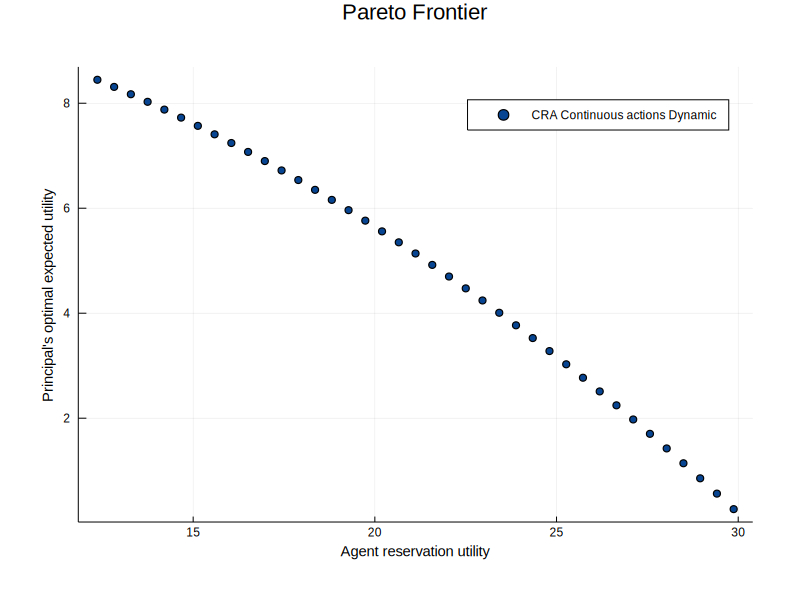

In [26]:
using Colors, ColorSchemes
Data = DataFrame(XLSX.readtable(string("Continuous_Actions/SDPA_y0408_h05",repr(h),".xlsx"), "Sheet1")...)
p = get(ColorSchemes.Blues_8, [i/4 for i in 1:4])
pl1=scatter(
    Data[:, "Utilidad_Agente"],
    Data[:,"Utilidad_Principal"],
    lw = 3,
labels = "CRA Continuous actions Dynamic",
    color = p[4],
    title = "Pareto Frontier", 
    legend = true,
    xlabel = "Agent reservation utility",
    ylabel =  "Principal's optimal expected utility") 
plot!(size = (800,600),
    xtickfont = font(8), 
    ytickfont = font(8), 
    guidefont = font(10), 
    titlefont = font(15),
    margin = 10mm) 
display(pl1)
#savefig("Continuous_Actions/Pareto_front_test8_scatter")

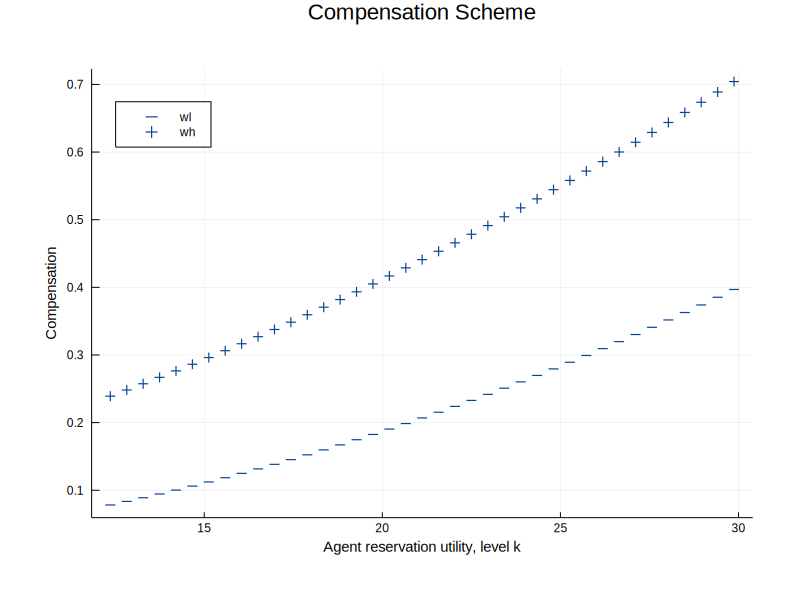

In [27]:
pl2=scatter(
[Data[:,"Utilidad_Agente"], Data[:,"Utilidad_Agente"]],
[Data[:,"Compensacion_YL"],Data[:,"Compensacion_YH"]], 
    markersize = 5,
    labels = ["wl" "wh"],
    color = [p[4] p[4]],
    shape = [:hline :+ :utri ],
    title = "Compensation Scheme",     
    legend = true,
    label = ["Wl" "Wh"],
    xlabel = "Agent reservation utility, level k",
    ylabel = "Compensation") #Se grafica K vs. Esquema de compensacion
plot!(size = (800,600),
    xtickfont = font(8), 
    ytickfont = font(8), 
    guidefont = font(10), 
    legendfont = font(8), 
    titlefont = font(15),
    #legend=:bottomright,
    legend = :topleft,
    margin = 10mm) #tamaño de letras
display(pl2)
#savefig("Continuous_Actions/Compensation_Scheme_test5")

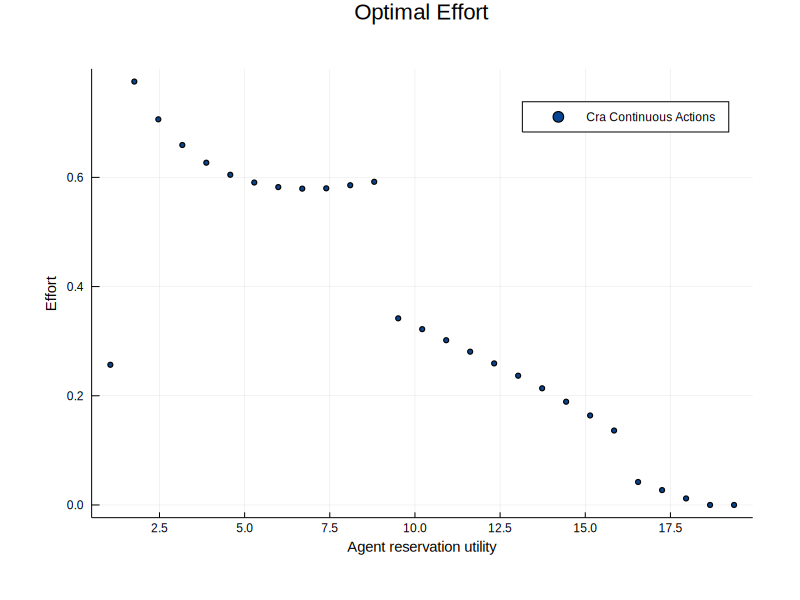

In [27]:
pl3=scatter(
    Data[:,"Utilidad_Agente"],
    Data[:,"Accion_Recomendada"],
    markersize = 3,
    labels = "Cra Continuous Actions",
    color = [p[4]],
    title ="Optimal Effort", 
    label = false,
    xlabel = "Agent reservation utility",
    ylabel = "Effort") #Se grafica K vs. accion sugerida
plot!(size = (800,600),
    xtickfont = font(8), 
    ytickfont = font(8), 
    guidefont = font(10), 
    titlefont = font(15),
    legend = :topright,
    margin = 10mm) #tamaño de letras
display(pl3)
#savefig("Continuous_Actions/Optimal_Effort_test5")

### Animation Plot 

#### Libraries 

In [15]:
using Plots, Plots.PlotMeasures    # Plots packages load
using DataFrames
using ExcelFiles
using XLSX

#### Plotting

#### Pareto Frontier Animation 

In [ ]:
theme(:ggplot2)     # Graphics theme

anim = @animate for h_now = 10:99
    Data_h = DataFrame(XLSX.readtable(string("DataEstPointh",repr.(round(h_now/100,digits = 2)),".xlsx"), "Sheet1")...)
    Principal_Utilities = Data_h[4:end,"Utilidad_Principal"]
    K = Data_h[4:end,"K"]
    plot(K, Principal_Utilities, 
    xlabel = "Agent reservation utility, level k",
    ylabel =  "Principal's optimal expected utility",
    title="Pareto Frontier for different levels of h.",
    labels = string("h=",repr(h_now/100)),
    legend = :topright,
    ylims=(0,20), 
    xlims=(0,100))
    
end
 
gif(anim, "Principal_Utilities_varying_h_Dynamic.gif", fps = 5)

#### Compensation Scheme Animation 

In [ ]:
theme(:ggplot2)     # Graphics theme

anim = @animate for h_now = 10:99
    Data_h = DataFrame(XLSX.readtable(string("DataEstPointh",repr.(round(h_now/100,digits = 2)),".xlsx"), "Sheet1")...)
    High_Compensations = Data_h[4:end,"Compensacion_YH"]
    Low_Compensations = Data_h[4:end,"Compensacion_YL"]
    K = Data_h[4:end,"K"]
    scatter(K, [Low_Compensations, High_Compensations], 
    shape=[:hline :+ :utri],
    markersize=8,
    title="Compensation for different levels of h.", 
    legend=:topleft,
    label=[string("WL, h=",repr(h_now/100)) string("Wh, h=",repr(h_now/100)) ],
    xlabel = "Agent reservation utility, level k",
    ylabel="Compensation",
    ylims=(0,0.8), 
    xlims=(10,100))
    
end
 
gif(anim, "Dynamic_Compensation_varying_h.gif", fps = 5)

In [ ]:
theme(:ggplot2)     # Graphics theme

anim = @animate for h_now = 10:99
    Data_h = DataFrame(XLSX.readtable(string("DataEstPointh",repr.(round(h_now/100,digits = 2)),".xlsx"), "Sheet1")...)
    VFH = Data_h[4:end,"VFH"]
    VFL = Data_h[4:end,"VFL"]
    K = Data_h[4:end,"K"]
    scatter(K, [VFL, VFH], 
    shape=[:hline :+ :utri],
    markersize=8,
    title="Promised Discounted Utility for different levels of h.", 
    legend=:topleft,
    label=[string("VFL, h=",repr(h_now/100)) string("VFH, h=",repr(h_now/100)) ],
    xlabel = "Agent reservation utility, level k",
    ylabel="Promised Discounted Utility",
    ylims=(0,100), 
    xlims=(0,100))
    
end
 
gif(anim, "Promised_Utility_varying_h.gif", fps = 5)